## 6. Despliegue

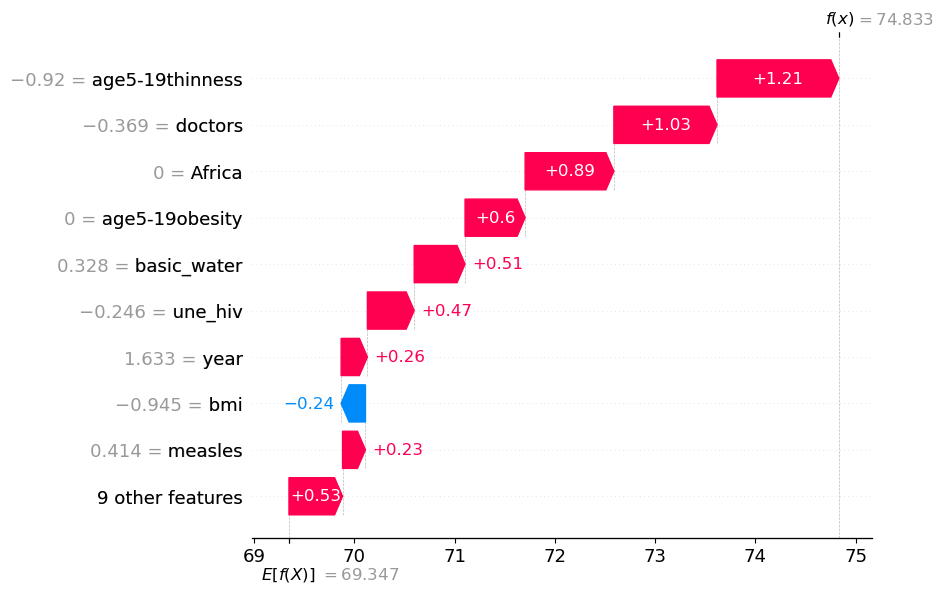

In [1]:
import tkinter as tk
from tkinter import messagebox
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

# Cargar el modelo y el escalador
with open('final_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Crear la ventana principal
root = tk.Tk()
root.title("Predictor de Esperanza de Vida")

# Crear los campos de entrada para los parámetros
entries = {}
params = ['year', 'une_pop', 'une_gni', 'gghe-d', 'che_gdp', 'une_edu_spend', 'basic_water', 'doctors', 
          'bmi', 'age5-19thinness', 'age5-19obesity', 'alcohol', 'hepatitis', 'measles', 
          'polio', 'diphtheria', 'une_hiv']

for param in params:
    tk.Label(root, text=param).grid(row=params.index(param), column=0)
    entry = tk.Entry(root)
    entry.grid(row=params.index(param), column=1)
    entries[param] = entry

# Añadir opción de selección de región
tk.Label(root, text="region").grid(row=len(params), column=0)
region_var = tk.StringVar(root)
region_var.set("Africa")  # Valor predeterminado
region_options = ["Africa", "Eastern Mediterranean", "South-East Asia", "Americas", "Europe", "Western Pacific"]
region_menu = tk.OptionMenu(root, region_var, *region_options)
region_menu.grid(row=len(params), column=1)

# Función para hacer la predicción y mostrar el gráfico SHAP
def predict():
    try:
        # Obtener los valores ingresados por el usuario
        user_input = []
        for param in params:
            try:
                value = float(entries[param].get())
                user_input.append(value)
            except ValueError:
                messagebox.showerror("Error", f"Por favor, ingrese un valor numérico válido para {param}.")
                return
        
        # Convertir a DataFrame y estandarizar
        try:
            user_input_df = pd.DataFrame([user_input], columns=params)
            user_input_scaled = scaler.transform(user_input_df)
            user_input_scaled_df = pd.DataFrame(user_input_scaled, columns=params)
        except Exception as e:
            messagebox.showerror("Error", f"Error al estandarizar los datos: {e}")
            return
        
        # Añadir la región al DataFrame
        try:
            region = 1 if region_var.get() == "Africa" else 0
            user_input_scaled_df['Africa'] = region
        except Exception as e:
            messagebox.showerror("Error", f"Error al añadir la región: {e}")
            return
        
        # Hacer la predicción
        try:
            prediction = model.predict(user_input_scaled_df)[0]
        except Exception as e:
            messagebox.showerror("Error", f"Error al hacer la predicción: {e}")
            return
        
        # Calcular los valores SHAP
        try:
            explainer = shap.Explainer(model)
            shap_values = explainer(user_input_scaled_df)
        except Exception as e:
            messagebox.showerror("Error", f"Error al calcular los valores SHAP: {e}")
            return
        
        # Crear gráfico de cascada SHAP
        try:
            shap.plots.waterfall(shap_values[0])
        except Exception as e:
            messagebox.showerror("Error", f"Error al crear el gráfico SHAP: {e}")
            return
        
        # Mostrar la predicción y el gráfico
        messagebox.showinfo("Predicción", f"La esperanza de vida predicha es: {prediction:.2f} años")
        
    except Exception as e:
        messagebox.showerror("Error Inesperado", f"Ocurrió un error inesperado: {e}")

# Botón para hacer la predicción
tk.Button(root, text="Predecir", command=predict).grid(row=len(params)+1, columnspan=2)

# Ejecutar la aplicación
root.mainloop()
